## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

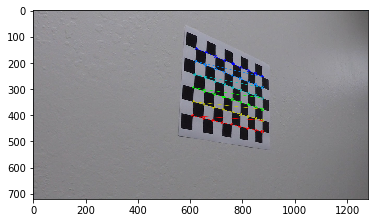

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mtimage

%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mtimage.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

# Load one of the calibration image to get the image shape
calibration_img_path='../camera_cal/calibration1.jpg'
calibration_img = mtimage.imread(calibration_img_path)

# Calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, (calibration_img.shape[1], calibration_img.shape[0]), None, None)

## Apply a distortion correction to raw images

In [2]:
def undistort(distorted_image, mtx, dist):
    return cv2.undistort(distorted_image, mtx, dist, None, mtx)

def demo_undistort(image_path, mtx, dist):
    original = mtimage.imread(image_path)
    undistorted = undistort(original, mtx, dist)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    
    ax1.imshow(original)
    ax1.set_title("Original Image", fontsize=20)
    
    ax2.imshow(undistorted)
    ax2.set_title("Undistorted Image", fontsize=20)
    
    plt.show()

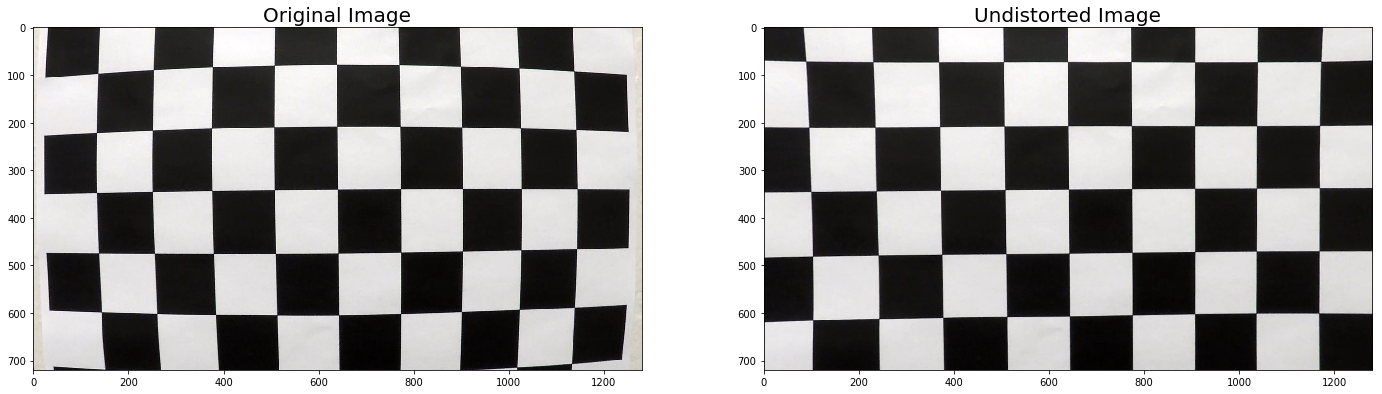

In [3]:
demo_undistort('../camera_cal/calibration1.jpg', mtx, dist)

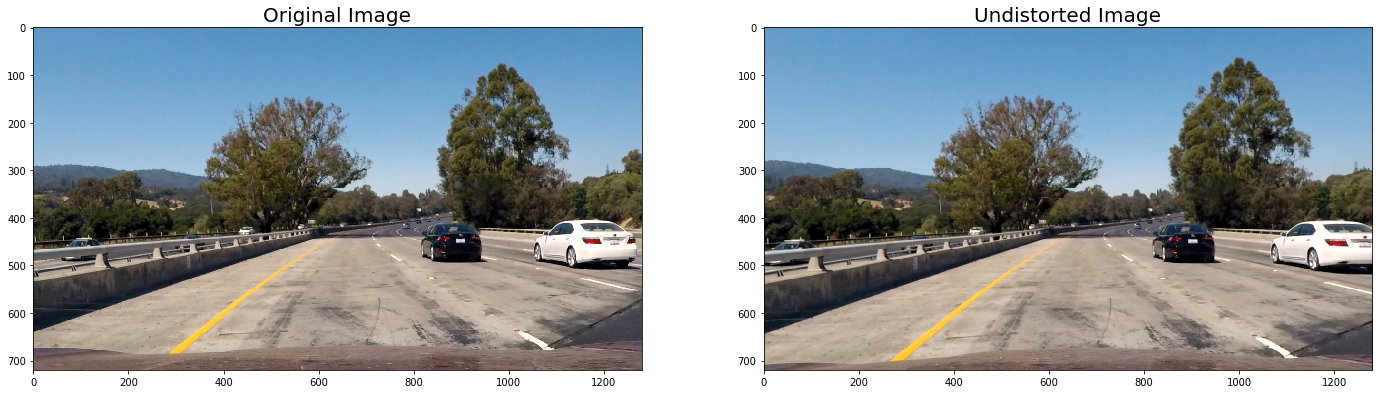

In [4]:
demo_undistort('../test_images/test1.jpg', mtx, dist)

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [5]:
image = mtimage.imread('../problem1.jpg')

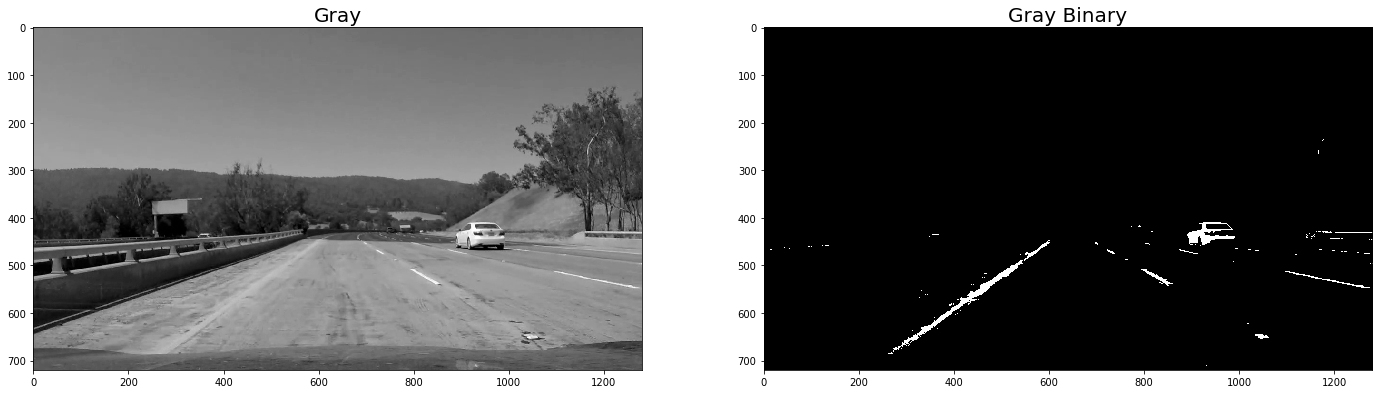

In [6]:
def demo_gray_binary(image, thresh=(180, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    
    f, axis = plt.subplots(1, 2, figsize=(24, 9))
    axis = axis.ravel()
    
    for i, (title, image) in zip(range(0, 2), zip(['Gray', 'Gray Binary'], [gray, binary])):
        axis[i].imshow(image, cmap='gray')
        axis[i].set_title(title, fontsize=20)
    plt.show()    

demo_gray_binary(image)

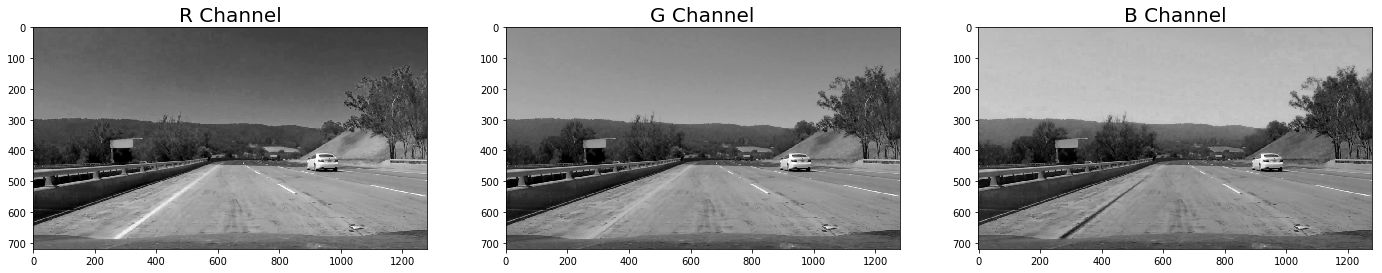

In [7]:
def demo_rgb(image):
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]

    f, axis = plt.subplots(1, 3, figsize=(24, 9))
    axis = axis.ravel()
    
    for i, (title, image) in zip(range(0, 3), zip(['R Channel', 'G Channel', 'B Channel'], [R, G, B])):
        axis[i].imshow(image, cmap='gray')
        axis[i].set_title(title, fontsize=20)
    plt.show()
    
demo_rgb(image)

The R channel does a reasonable job of highlighting the lines, and you can apply a similar threshold to find lane-line pixels:

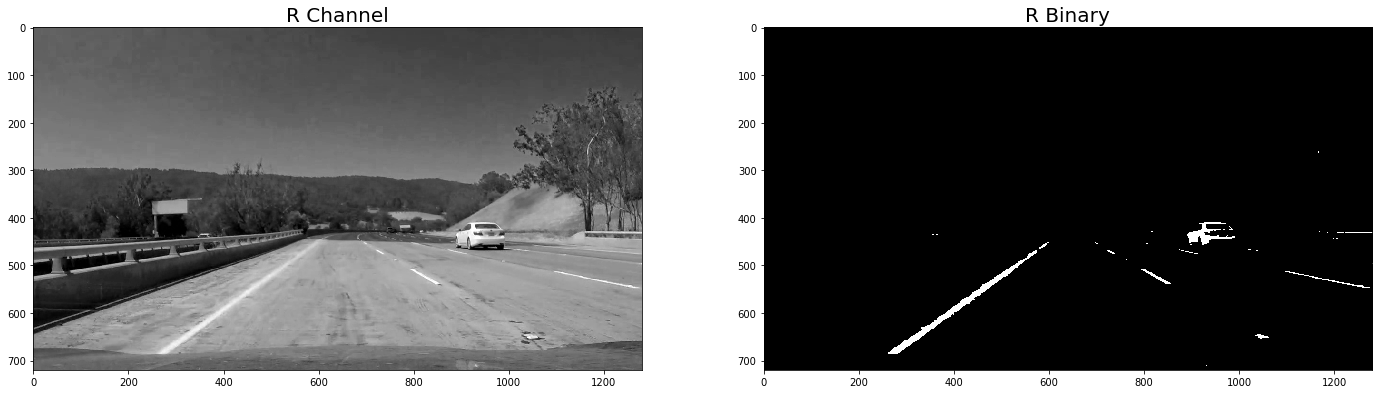

In [8]:
def demo_rgb_binary(image, channel='R', thresh = (200, 255)):    
    channels = dict()
    channels['R'] = 0
    channels['G'] = 1
    channels['B'] = 2    
    
    img = image[:,:,channels[channel]]
    
    binary = np.zeros_like(img)
    binary[(img > thresh[0]) & (img <= thresh[1])] = 1
    
    f, axis = plt.subplots(1, 2, figsize=(24, 27))
    axis = axis.ravel()
    
    for i, (title, image) in zip(range(0, 2), zip([channel + ' Channel', channel + ' Binary'], [img, binary])):
        axis[i].imshow(image, cmap='gray')
        axis[i].set_title(title, fontsize=20)
    plt.show()
    
demo_rgb_binary(image, 'R')

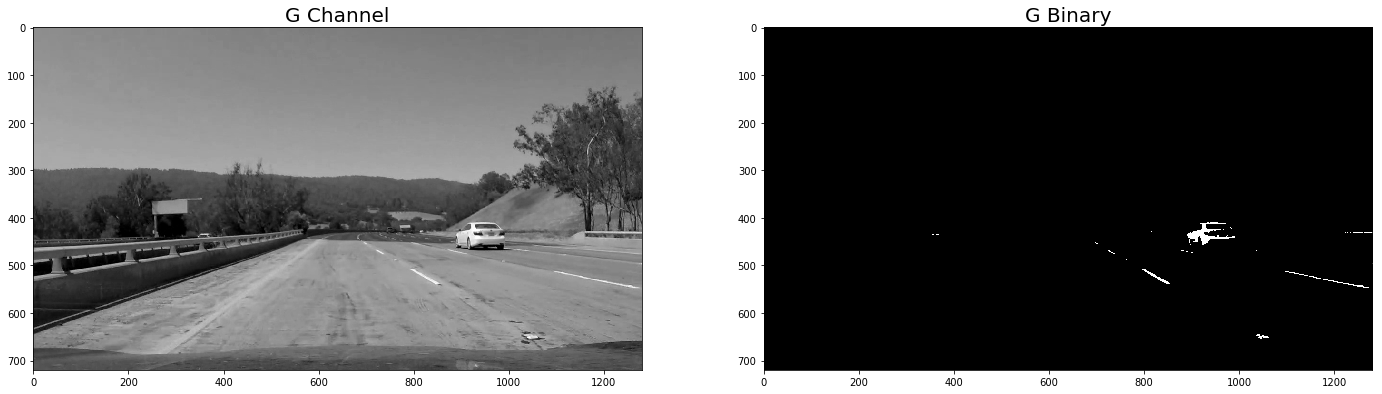

In [9]:
demo_rgb_binary(image, 'G')

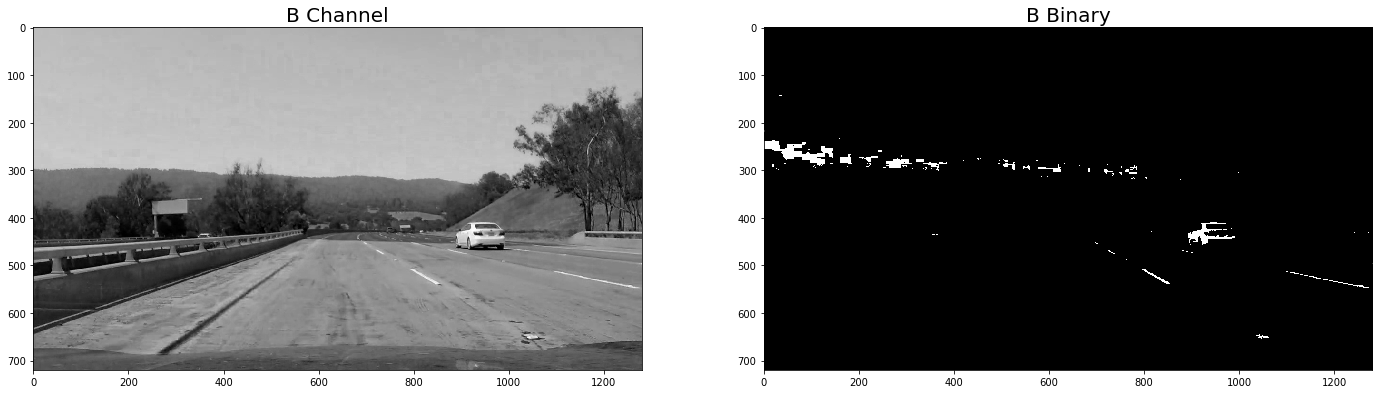

In [10]:
demo_rgb_binary(image, 'B')

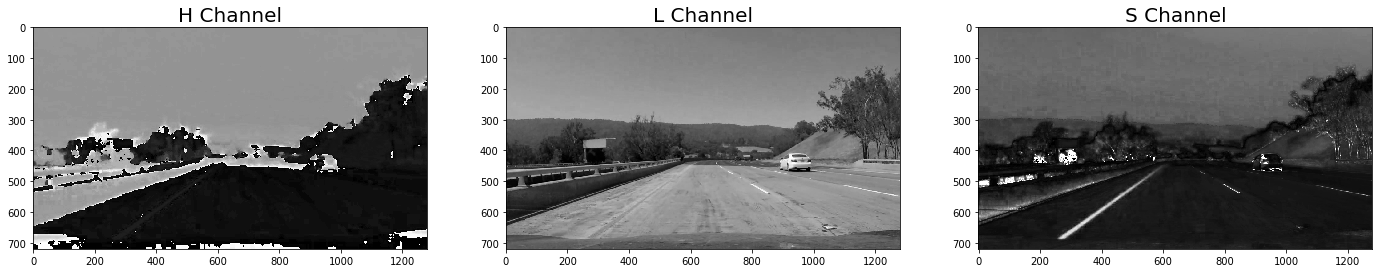

In [11]:
def demo_hls(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    f, axis = plt.subplots(1, 3, figsize=(24, 9))
    axis = axis.ravel()
    
    for i, (title, image) in zip(range(0, 3), zip(['H Channel', 'L Channel', 'S Channel'], [H, L, S])):
        axis[i].imshow(image, cmap='gray')
        axis[i].set_title(title, fontsize=20)
    plt.show()
    
demo_hls(image)

The S channel picks up the lines well, so let's try applying a threshold there:

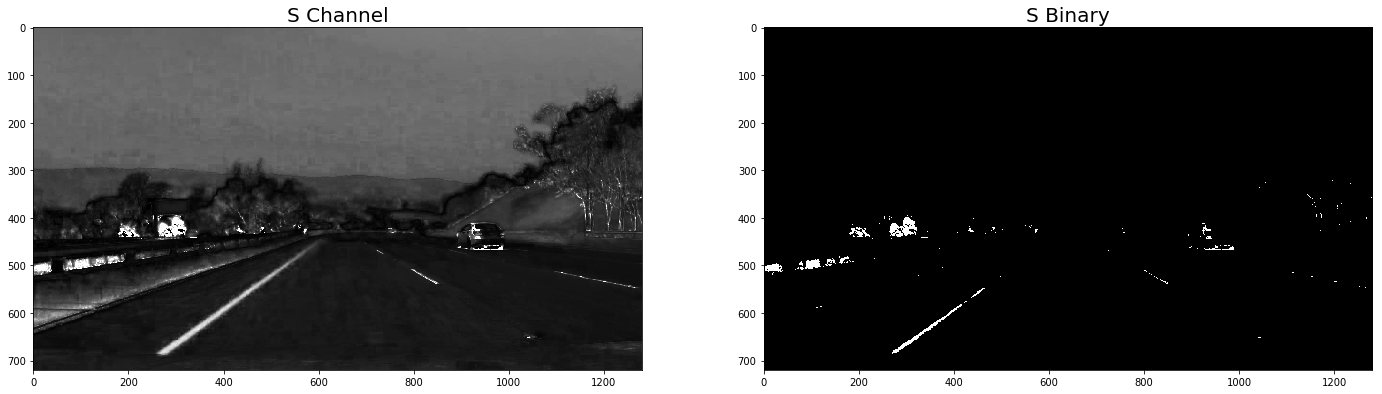

In [12]:
def demo_s_binary(image, thresh = (200, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    f, axis = plt.subplots(1, 2, figsize=(24, 9))
    axis = axis.ravel()
    
    for i, (title, image) in zip(range(0, 2), zip(['S Channel', 'S Binary'], [S, binary])):
        axis[i].imshow(image, cmap='gray')
        axis[i].set_title(title, fontsize=20)
    plt.show()
    
demo_s_binary(image)

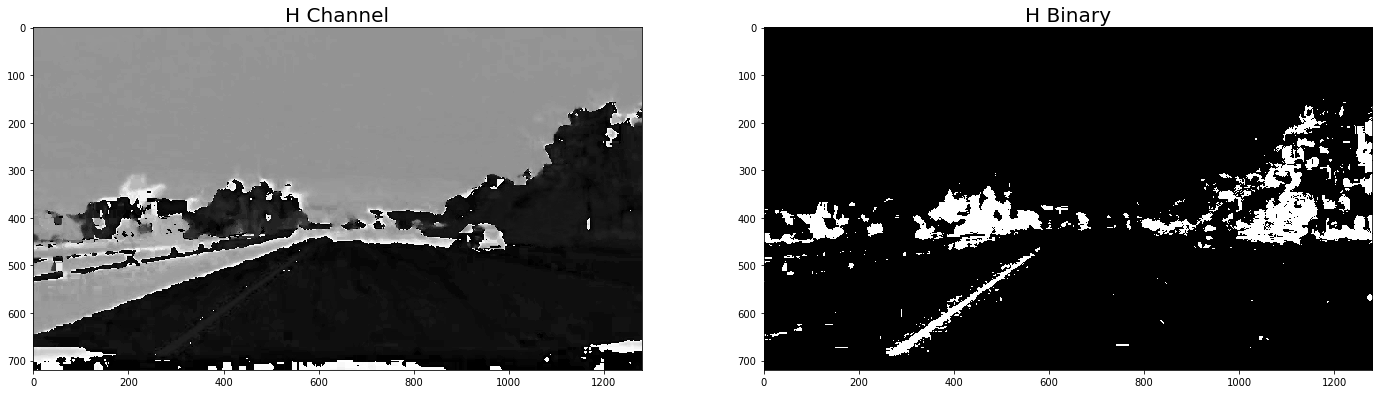

In [13]:
def demo_h_binary(image, thresh = (15, 100)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    
    binary = np.zeros_like(H)
    binary[(H > thresh[0]) & (H <= thresh[1])] = 1
    
    f, axis = plt.subplots(1, 2, figsize=(24, 9))
    axis = axis.ravel()
    
    for i, (title, image) in zip(range(0, 2), zip(['H Channel', 'H Binary'], [H, binary])):
        axis[i].imshow(image, cmap='gray')
        axis[i].set_title(title, fontsize=20)
    plt.show()
    
demo_h_binary(image)

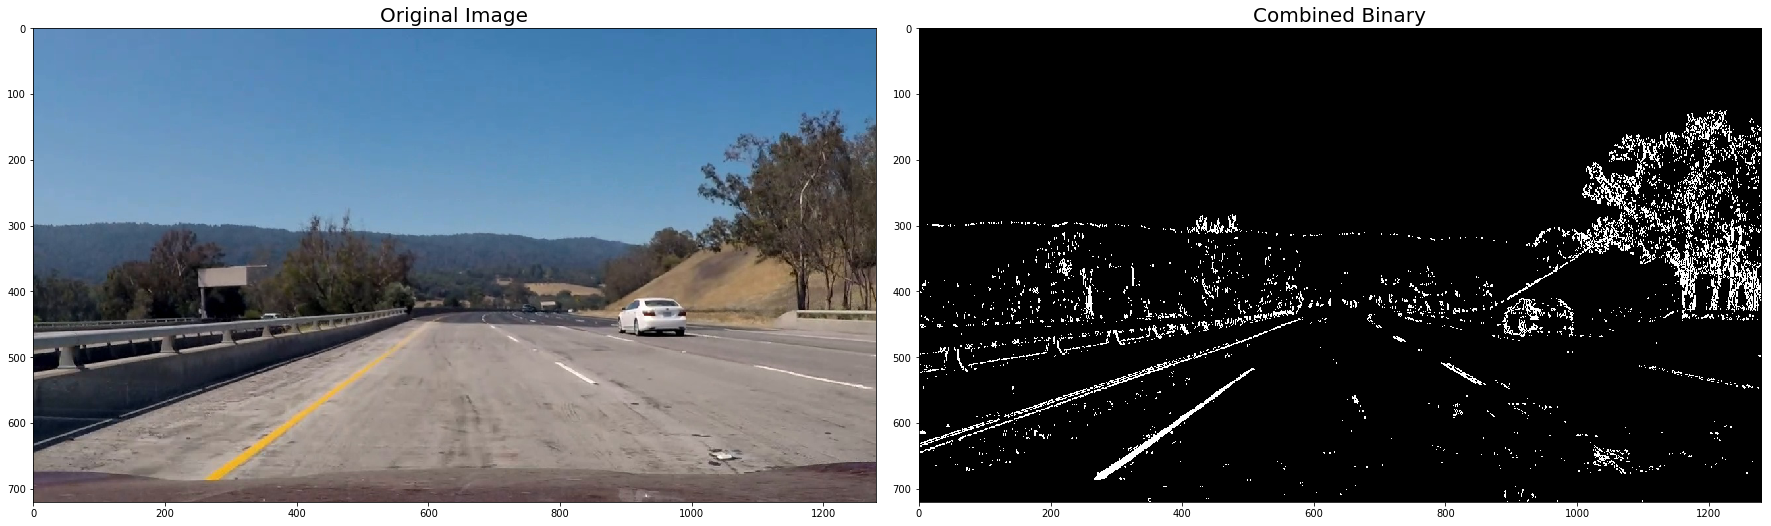

In [14]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100), R_thresh=(5, 255), sobel_kernel = 3):    
    # Pull R
    R = img[:,:,0]
    
    # Threshold R color channel
    R_binary = np.zeros_like(R)
    R_binary[(R >= R_thresh[0]) & (R <= R_thresh[1])] = 1
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold S channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    
    # Combine the binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((R_binary == 1)) & ((sxbinary == 1) | (s_binary == 1))] = 1    
    
    return combined_binary

binary = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(binary, cmap='gray')
ax2.set_title('Combined Binary', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

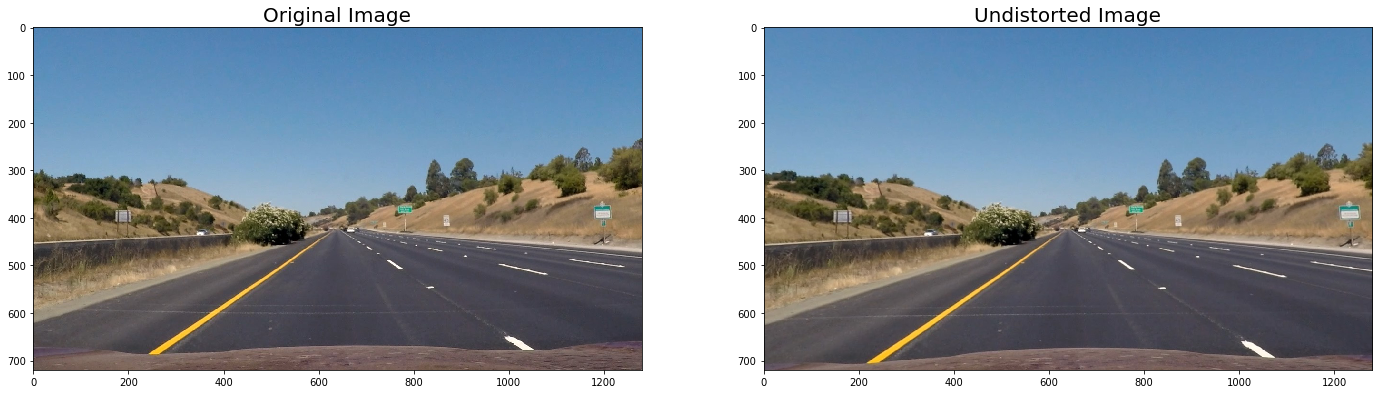

In [15]:
demo_undistort('../test_images/straight_lines1.jpg', mtx, dist)

In [16]:
def warper(image, src, dst):
    h, w = image.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(image, M, (w,h))
    
    return warped, M, Minv

In [17]:
def draw_border(img, points):
    corners = [tuple(p) for p in points]
    cv2.line(img, corners[0], corners[1], color=[255,0,0], thickness=3)
    cv2.line(img, corners[1], corners[2], color=[255,0,0], thickness=3)
    cv2.line(img, corners[2], corners[3], color=[255,0,0], thickness=3)
    cv2.line(img, corners[3], corners[0], color=[255,0,0], thickness=3)    

def birds_eye_view(image, mtx, dist):
    # Get binary thresholded image
    binary = pipeline(image)
 
    # Undistort the image using calibration params found earlier
    undistorted = undistort(binary, mtx, dist)
    
    # Do perspective transform
    # Grab the image shape    
    h, w = img.shape[:2]
    img_size = (w, h)   
    
    # Source points - defined area of lane line edges
    src = np.float32([[690,450],[1115,img_size[1]],[185,img_size[1]],[595,450]])

    # 4 destination points to transfer
    offset = 300 # offset for dst points
    dst = np.float32([[img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]],
                      [offset, img_size[1]],[offset, 0]])
    
    unwarped, M, Minv = warper(binary, src, dst)    
    
    return binary, unwarped, M, Minv, src, dst


def demo_birds_eye_view(img, mtx, dist):
    binary, unwarped, M, Minv, src, dst = birds_eye_view(img, mtx, dist)
    
    binary = 255 * np.dstack((binary, binary, binary))
    unwarped = 255 * np.dstack((unwarped, unwarped, unwarped))
    
    draw_border(binary, src)
    draw_border(unwarped, dst)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    
    ax1.imshow(binary)
    ax1.set_title('Thresholded image with source points drawn', fontsize=20)
   
    ax2.imshow(unwarped)
    ax2.set_title('Warped Image with dest. points drawn', fontsize=20)
    plt.show()

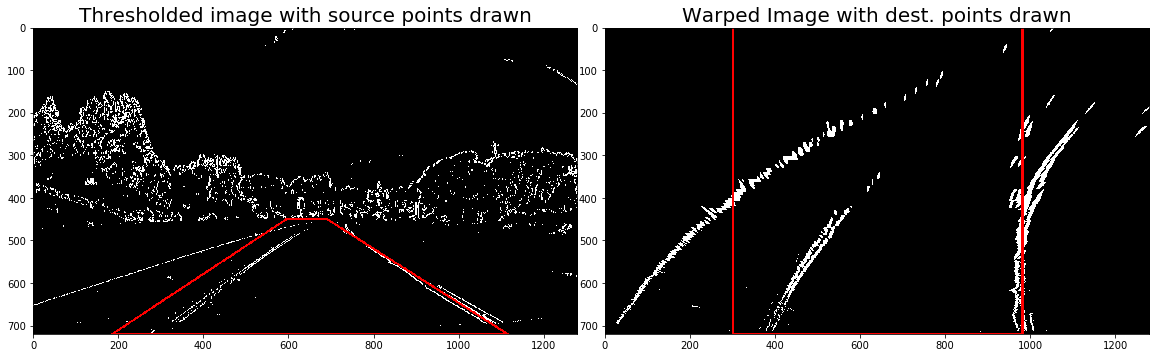

In [31]:
#img = mtimage.imread('../test_images/straight_lines1.jpg')
img = mtimage.imread('../capture/1526986549.jpg')
demo_birds_eye_view(img, mtx, dist)

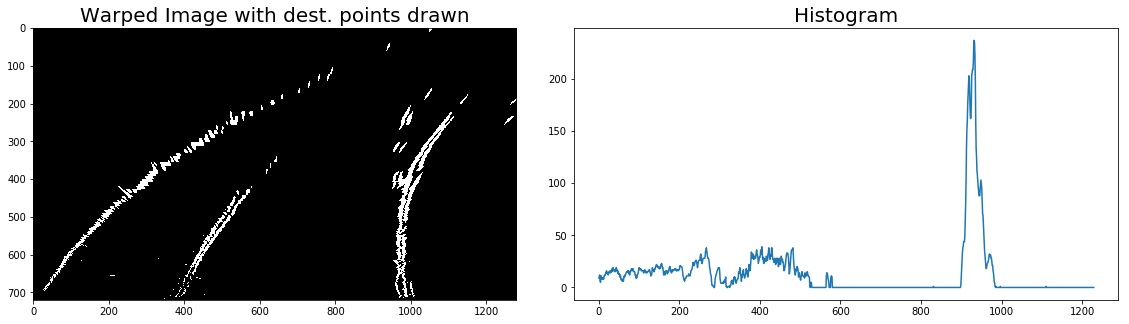

In [44]:
import numpy as np

binary, binary_warped, M, Minv,_,_ = birds_eye_view(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
f.subplots_adjust(hspace = .2, wspace=.05)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,50:], axis=0)

ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Warped Image with dest. points drawn', fontsize=20)

ax2.plot(histogram)
ax2.set_title('Histogram', fontsize=20)

plt.show()    

In [33]:
def fit_lane_lines(binary_warped):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_lane_inds, left_fit, right_lane_inds, right_fit, out_img

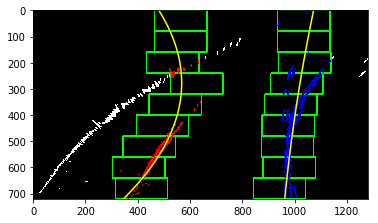

In [34]:
left_lane_inds, left_fit, right_lane_inds, right_fit, out_img = fit_lane_lines(binary_warped)

def plot_lane_window(binary_warped, left_lane_inds, left_fit, right_lane_inds, right_fit, out_img):    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return left_fitx, right_fitx
    
left_fitx, right_fitx = plot_lane_window(binary_warped, left_lane_inds, left_fit, right_lane_inds, 
                                         right_fit, out_img)

(720, 0)

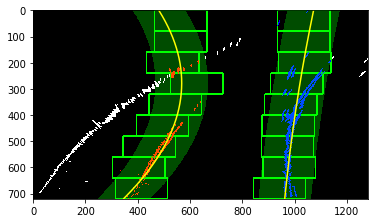

In [35]:
margin = 100
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
    
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

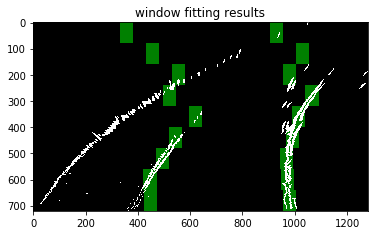

In [36]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def demo_window_centroids(warped):
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
    plt.imshow(output)
    plt.title('window fitting results')
    plt.show()
    
demo_window_centroids(binary_warped)

In [37]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
def calc_curvature(ploty, left_fitx, right_fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad
    

left_curverad, right_curverad = calc_curvature(ploty, left_fitx, right_fitx)

# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

148.290776358 m 2155.67427823 m


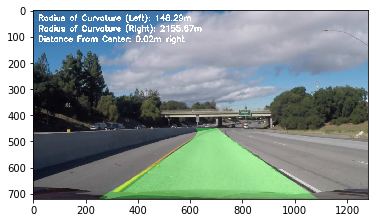

In [38]:
def show_lane(img, binary_warped, left_fit, right_fit):
    midx = 650
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

   
    left_curverad, right_curverad = calc_curvature(ploty, left_fitx, right_fitx)

    cv2.putText(result,'Radius of Curvature (Left): %.2fm' % left_curverad,(20,40),
                cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 3)

    cv2.putText(result,'Radius of Curvature (Right): %.2fm' % right_curverad,(20,80),
                cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 3)

    x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    position_from_center = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix

    if position_from_center < 0:
        text = 'left'
    else:
        text = 'right'

    cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),
                (20,120), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 3)
    
    return result
    
result = show_lane(img, binary_warped, left_fit, right_fit)
plt.imshow(result)
plt.show()

In [39]:
def process_image(img):
    #cv2.imwrite('{}.jpg'.format(int(time.time())), cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    binary, binary_warped, M, Minv,_,_ = birds_eye_view(img, mtx, dist)
    
    left_lane_inds, left_fit, right_lane_inds, right_fit, out_img = fit_lane_lines(binary_warped)
    result = show_lane(img, binary_warped, left_fit, right_fit)
    
    return result

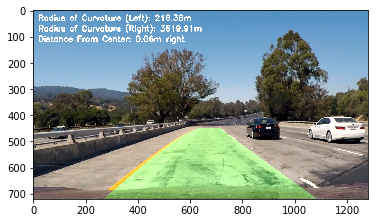

In [40]:
result = process_image(mtimage.imread('../test_images/test1.jpg'))
plt.imshow(result)
plt.show()

In [41]:
# # Import everything needed to edit/save/watch video clips
# from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_result.mp4'
# clip1 = VideoFileClip("../project_video.mp4")#.subclip(38,43)
# white_clip = clip1.fl_image(process_image)
# %time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [42]:
challenge_output = 'challenge_video_result.mp4'
# clip1 = VideoFileClip("../challenge_video.mp4")#.subclip(38,43)
# white_clip = clip1.fl_image(process_image)
# %time white_clip.write_videofile(challenge_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [43]:
def extractImages(pathIn, folder):
    vidcap = cv2.VideoCapture(pathIn)
    count = 0
    while True:
        success,image = vidcap.read()
        if not success:
            break
        cv2.imwrite(os.path.join(folder,"frame{:d}.jpg".format(count)), image)     # save frame as JPEG file
        count += 1
    print("{} images are extacted in {}.".format(count, folder))
    
print(cv2.__version__)
extractImages('../project_video.mp4', 'capture')

3.1.0
0 images are extacted in capture.
